In [1]:
import pandas as pd
import numpy as np
from bioinfokit.analys import norm
from rpy2 import robjects
from rpy2.robjects import r,pandas2ri
from rpy2.robjects.packages import importr
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost
from sklearn.decomposition import PCA
import shap
import math
from scipy import stats
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
import matplotlib.patches as mpatches
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans

/Users/shi/opt/anaconda3/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version. The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex


In [2]:
cnt= pd.read_csv("count_IMvigor210_N298.csv", header=0,index_col=0) 
metadata = pd.read_csv("metadata_IMvigor210_N298.csv", header=0)
nm = norm()
nm.tpm(df=cnt, gl='Length')
tpm = nm.tpm_norm
tpm = tpm[~tpm.index.duplicated()]
tpm = tpm.dropna()
tpm = tpm[tpm.mean(axis=1) >= 0]
##########
sam_1 = metadata[metadata["label"] == 1]["id"].tolist()
sam_0 = metadata[metadata["label"] == 0]["id"].tolist()
sam_all = sam_1 + sam_0
tpm = tpm[sam_all]
tpm = np.log2(tpm + 1)
tpm

,SAMd027124354ce,SAMbf1a3ae828e6,SAM2e9ac0b1b250,SAM30b5c6c54cf7,SAMd35318127278,SAM560f23d6a3ad,SAM73663ee4a96e,SAMc2a1820d4e6b,SAMe1eb5d988760,SAM8a1b0e02ee42,...,SAMf20b827dca51,SAM6792d6e98068,SAM5cc2d9036053,SAM80c6183220e6,SAM1f83ebd6be9b,SAMe7e4f7c076a7,SAMc6eff056c89a,SAM5cfa1699bdb7,SAMda4d892fddc8,SAMe3d4266775a9
A1BG,2.166027,0.508185,3.249488,1.001434,0.685816,1.254024,1.516686,1.034129,0.866157,2.529901,...,1.782505,0.438148,2.425213,1.943651,0.309610,0.548716,0.892466,5.369222,1.896123,2.199709
NAT2,0.134138,0.748001,0.165302,0.000000,0.000000,0.153885,0.115295,0.070641,0.540331,0.568783,...,0.234960,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500549,0.000000,0.000000
ADA,4.935398,4.071487,4.225526,5.432950,4.129794,4.980992,4.209972,4.256524,4.560283,4.337712,...,5.430871,1.592323,4.162561,5.658997,2.308445,4.362667,4.102500,2.988546,5.166945,3.602627
CDH2,5.894632,2.319084,5.523936,2.077784,1.375779,4.980792,2.459577,2.647986,2.763013,0.689167,...,1.306843,0.422364,2.477770,2.966589,3.828078,3.330023,2.812540,5.691231,3.779975,2.040872
AKT3,2.810776,3.187945,2.928128,0.994997,0.924988,1.078463,1.650964,2.250768,2.765002,2.245277,...,2.356875,0.890569,2.446137,1.923435,0.992014,1.783858,1.657312,2.843039,1.285258,1.917956
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PTBP3,4.101352,5.489016,4.618000,5.219849,6.357359,5.239007,4.977425,4.792271,5.997859,4.687192,...,5.783021,5.439531,4.937927,6.034327,6.263501,6.157345,5.639928,5.171114,5.279726,6.228962
KCNE2,0.781676,1.015442,0.675660,0.287310,0.769322,0.127377,0.495034,0.656392,0.615623,0.338230,...,0.521188,0.333590,0.485990,0.533264,0.000000,0.244948,0.000000,0.184022,0.000000,0.187341
DGCR2,3.441991,3.136050,3.162762,2.744280,3.468980,3.614986,4.310776,3.548938,3.216997,3.351975,...,3.050657,3.178082,4.138087,3.366017,2.968049,2.497664,3.205061,3.649210,2.993765,3.882288
CASP8AP2,5.254889,5.269179,4.687361,4.536145,5.904862,4.512455,4.288716,4.856942,5.179028,5.004986,...,4.546669,3.776623,3.627429,4.376403,4.895531,4.304589,4.252124,4.285813,3.395531,5.092525


In [3]:
easyTCGA = importr('easyTCGA')
pandas2ri.activate()
front_columns = tpm.transpose().head(131).transpose()
back_columns =tpm.transpose().tail(167).transpose()
selected_data = pd.concat([front_columns, back_columns], axis=1)
expr = selected_data
clusters3 = ['a']*131+ ['b']*167
group =  robjects.FactorVector(clusters3)
deg_res1 = easyTCGA.diff_analysis(exprset=pandas2ri.DataFrame(expr), 
                                  group=group, 
                                  is_count=False, 
                                  save=False)
deg_limma = deg_res1.rx2('deg_limma')

R[write to console]: => log2 transform not needed

R[write to console]: => Running limma

R[write to console]: => Running wilcoxon test

R[write to console]: => Analysis done.



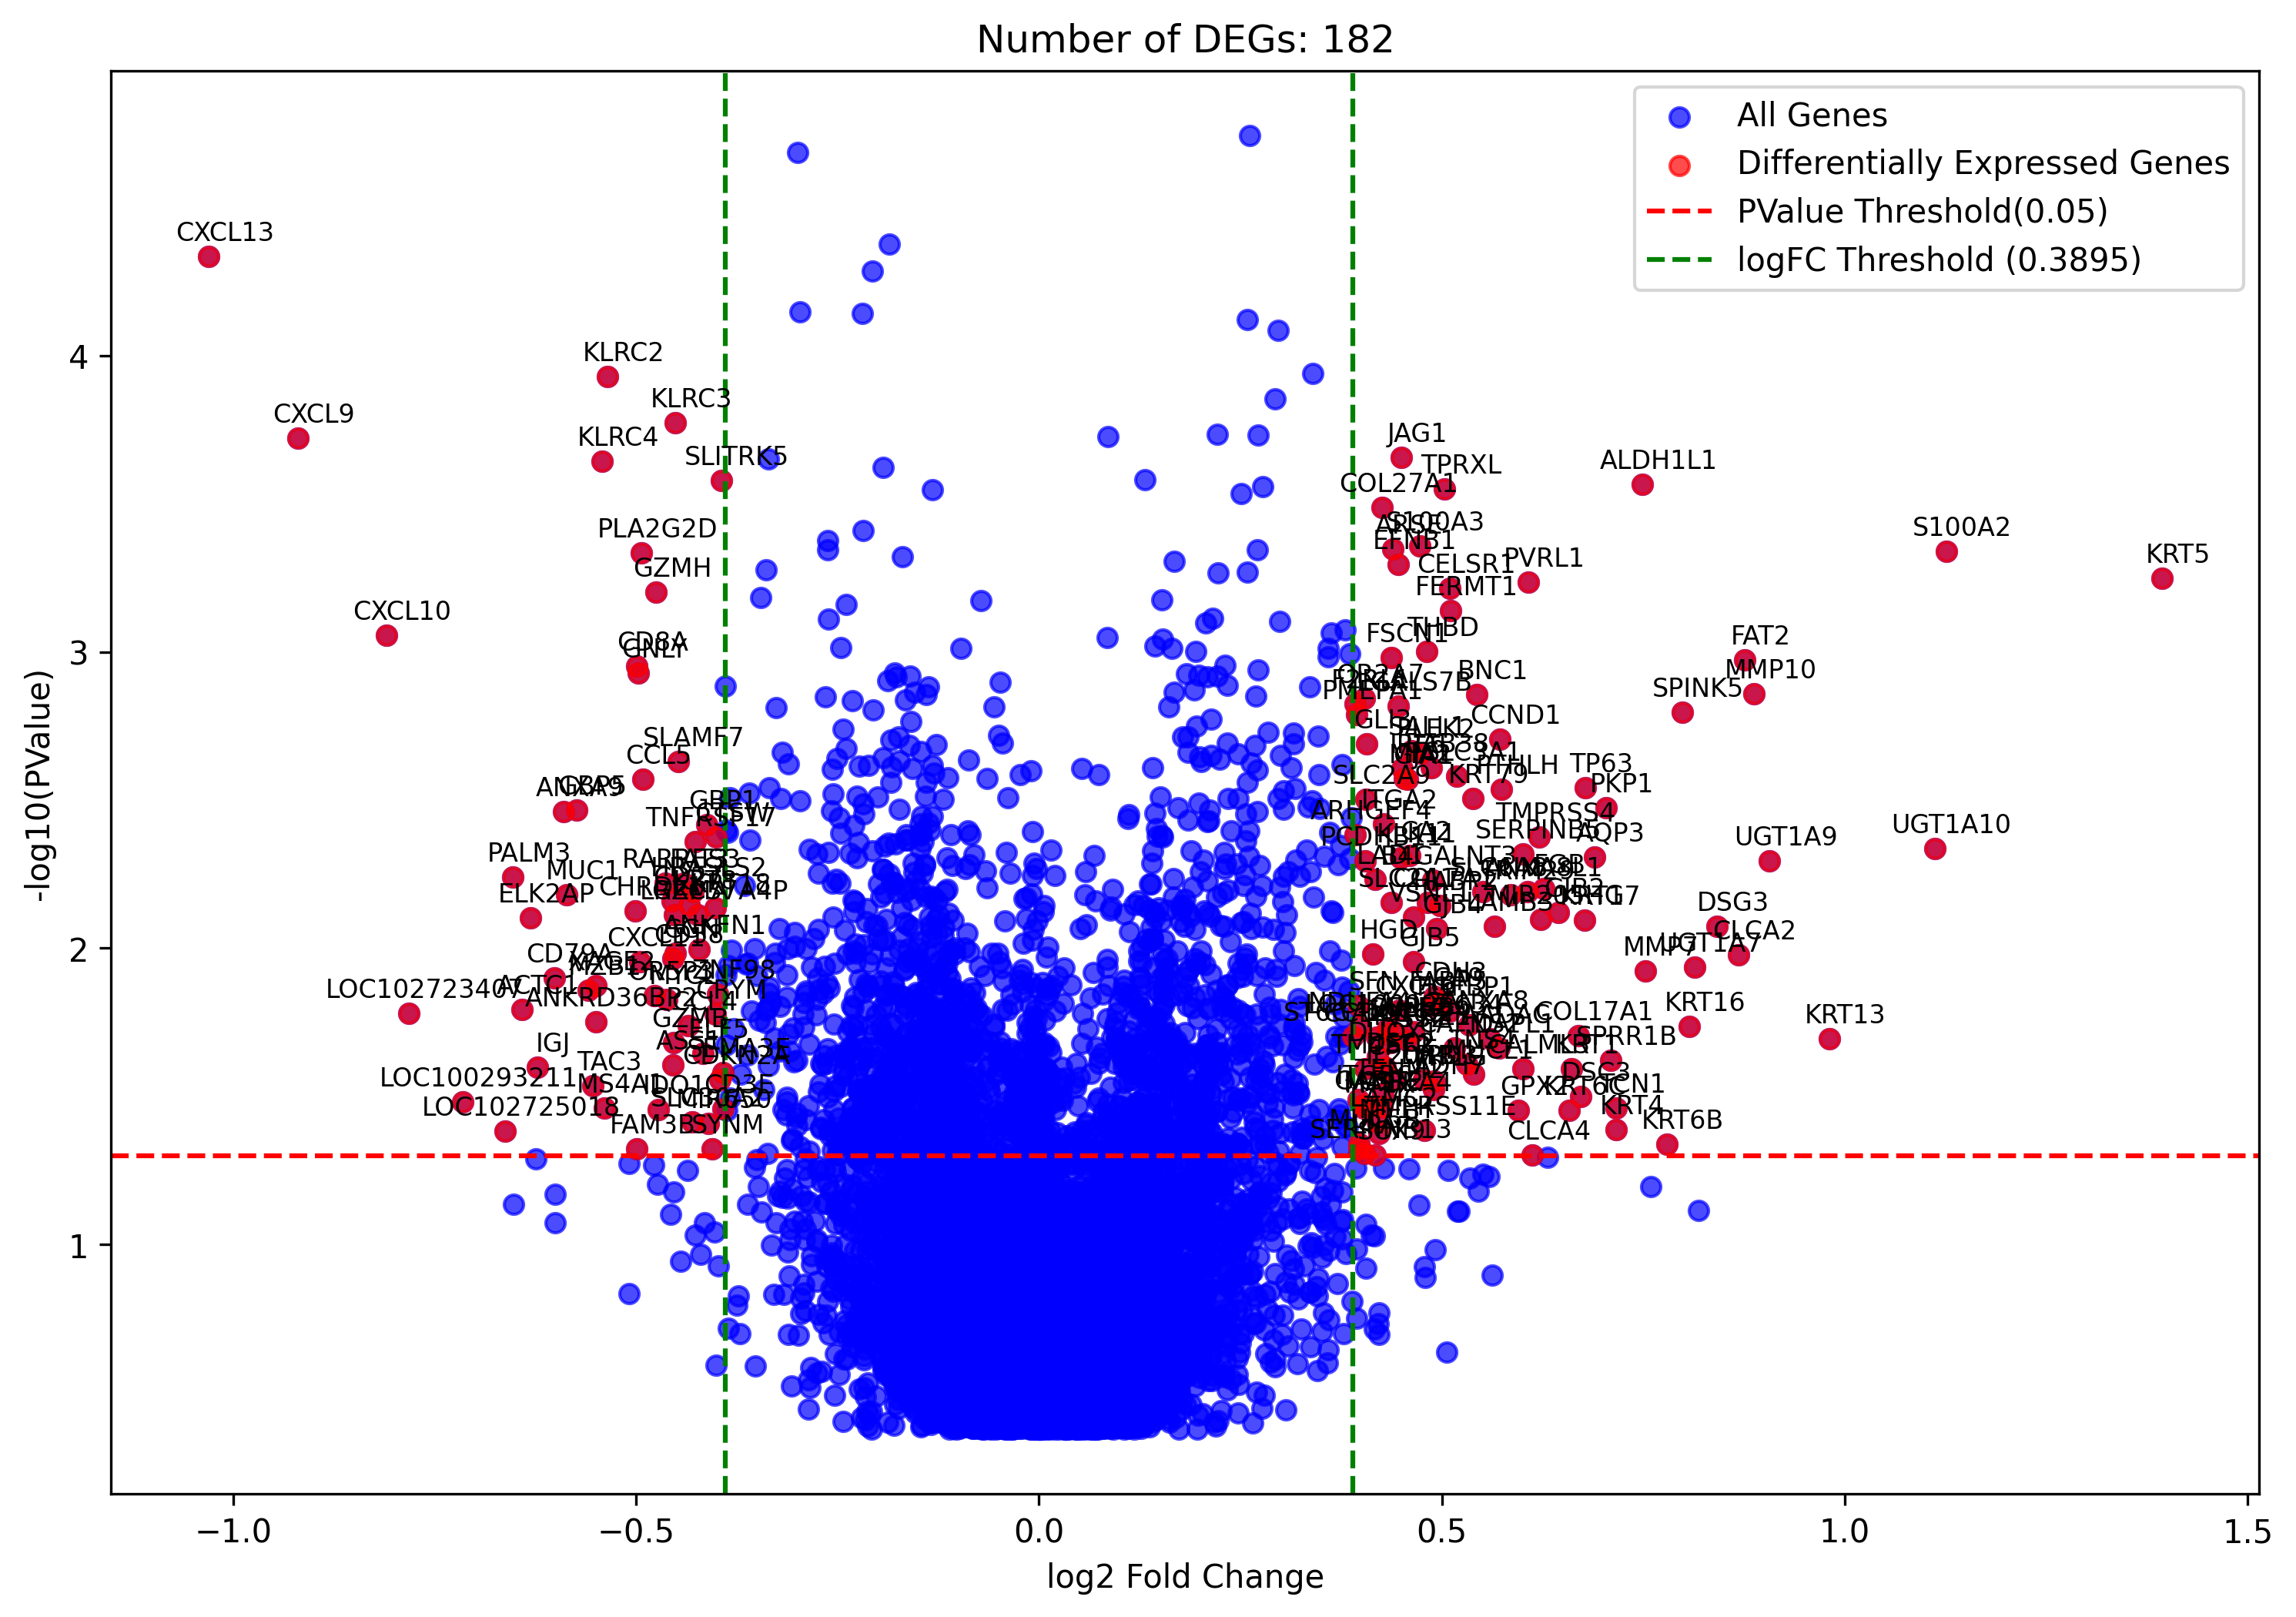

In [4]:
padj_threshold = 0.05
logFC_cutoff = 0.3895
filtered_rows = deg_limma[(deg_limma['logFC'].abs() > logFC_cutoff) & (deg_limma['P.Value'] < padj_threshold)]
selected_row_names = filtered_rows.index.tolist()
alldiff = deg_limma
alldiff = alldiff.rename(columns={'P.Value': 'PValue', 'adj.P.Val': 'adjPValue'})
data = {'logFC': alldiff['logFC'],  'PValue': alldiff['PValue'],'FDR': alldiff['adjPValue']}
volcano_data = pd.DataFrame(data)
diff = alldiff.query('(PValue < @padj_threshold) & ((logFC > @logFC_cutoff) | (logFC < -@logFC_cutoff))')
plt.figure(figsize=(12, 8),dpi = 300)
plt.scatter(volcano_data['logFC'], -np.log10(volcano_data['PValue']), color='blue', alpha=0.7, label='All Genes')
plt.scatter(diff['logFC'], -np.log10(diff['PValue']), color='red', alpha=0.7, label='Differentially Expressed Genes')

for i, row in diff.iterrows():
    plt.annotate(i, (row['logFC'], -np.log10(row['PValue'])),
                 textcoords="offset points", xytext=(5, 5), ha='center', fontsize=8, color='black')

plt.axhline(y=-np.log10(padj_threshold), color='red', linestyle='--', label=f'PValue Threshold({padj_threshold})')
plt.axvline(x=logFC_cutoff, color='green', linestyle='--', label=f'logFC Threshold ({logFC_cutoff})')
plt.axvline(x=-logFC_cutoff, color='green', linestyle='--')
plt.title(f'Number of DEGs: {len(diff)}')
plt.xlabel('log2 Fold Change')
plt.ylabel('-log10(PValue)')
plt.legend()
plt.show()

In [5]:
all_shap = tpm.transpose()[selected_row_names]
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    all_shap, 
    [1] * 131 + [0] * 167, 
    test_size=0.1, 
    random_state=36,
    stratify=[1] * 131 + [0] * 167
)

model = xgboost.XGBClassifier(subsample=1, alpha=1, eta=0.1)
model.fit(X_train, y_train)

shap.initjs()

explainer = shap.Explainer(model, X_train)
shap_values= explainer(X_train)  
shap_values_test = explainer(X_test) 
shap_values_values = np.concatenate([shap_values.values, shap_values_test.values], axis=0)

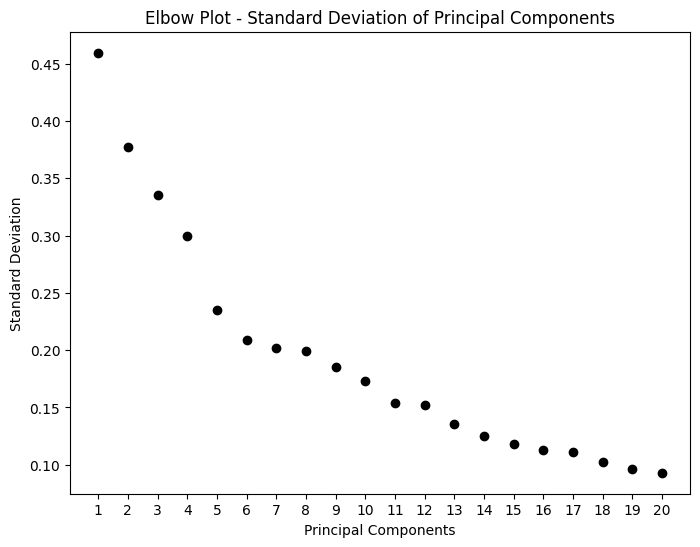

Principal Component 1 Standard Deviation: 0.45966871360847933
Principal Component 2 Standard Deviation: 0.377275989931475
Principal Component 3 Standard Deviation: 0.3351434211174273
Principal Component 4 Standard Deviation: 0.2999192045347393
Principal Component 5 Standard Deviation: 0.23530576133181852
Principal Component 6 Standard Deviation: 0.20899019018526732
Principal Component 7 Standard Deviation: 0.20201709861965614
Principal Component 8 Standard Deviation: 0.19899125248130414
Principal Component 9 Standard Deviation: 0.18533403964757847
Principal Component 10 Standard Deviation: 0.17301281884342204
Principal Component 11 Standard Deviation: 0.15383817042924583
Principal Component 12 Standard Deviation: 0.15194888935236228
Principal Component 13 Standard Deviation: 0.1359578496714499
Principal Component 14 Standard Deviation: 0.12476126327432492
Principal Component 15 Standard Deviation: 0.11848829395834372
Principal Component 16 Standard Deviation: 0.11326062384604811
Princi

In [6]:
num_components = 20
pca = PCA(n_components=num_components)
pca.fit(shap_values.values)
pca_components = pca.transform(shap_values.values)

std_deviation = np.std(pca_components, axis=0)
num_components = len(std_deviation)

plt.figure(figsize=(8, 6))
plt.scatter(range(1, num_components + 1), std_deviation, color='black', marker='o')
plt.title('Elbow Plot - Standard Deviation of Principal Components')
plt.xlabel('Principal Components')
plt.ylabel('Standard Deviation')
plt.xticks(np.arange(1, num_components + 1))
plt.show()
for i, std in enumerate(std_deviation):
    print(f"Principal Component {i+1} Standard Deviation: {std}")


In [9]:
def SC_nSNN(A, k, sigma):
    data_size = A.shape[0]
    B = np.zeros((data_size, data_size))  # Create a similarity matrix which is fully connected

    # Compute similarity matrix using Gaussian function
    for i in range(data_size):
        for j in range(data_size):
            B[i, j] = np.exp(-np.sum((A[i, :] - A[j, :]) ** 2) / (2 * sigma ** 2))
            B[j, i] = B[i, j]

    temp = np.array([sorted(row, reverse=True) for row in B])  # Recording the distance in B from big to small
    I = np.argsort(-B, axis=1)  # I is the corresponding id

    for i in range(k, data_size):
        temp[:, i] = 0

    # E is the similarity matrix of the k nearest neighbors
    E = np.zeros((data_size, data_size))
    for i in range(data_size):
        for j in range(k):
            E[i, I[i, j]] = temp[i, j]

    E[np.where(E != 0)] = 1  # Replace nonzero sparse matrix elements with ones
    G = np.copy(E)

    W = np.zeros((data_size, data_size))  # W is the similarity matrix of the shared nearest neighbors

    for i in range(data_size):
        for j in range(i + 1, data_size):
            diff = np.sum(np.abs(G[i, :] - G[j, :])) / 2
            W[i, j] = k - diff
            if G[i, j] != 0 and G[j, i] != 0:
                W[i, j] += 1
            W[i, j] /= k
            W[j, i] = W[i, j]

    return W

def spectral_clustering(similarity_matrix, num_clusters):

    # Normalized Laplacian Matrix
    degrees = np.sum(similarity_matrix, axis=1)
    sqrt_degrees = np.sqrt(degrees)
    normalized_laplacian = np.diag(1.0 / sqrt_degrees) @ (np.diag(degrees) - similarity_matrix) @ np.diag(1.0 / sqrt_degrees)

    # Eigen Decomposition
    eigenvalues, eigenvectors = np.linalg.eig(normalized_laplacian)
    sorted_indices = np.argsort(eigenvalues)
    sorted_eigenvectors = eigenvectors[:, sorted_indices[:num_clusters]]

    # K-means Clustering on Eigenvectors
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    clusters = kmeans.fit_predict(np.real(sorted_eigenvectors))

    return clusters

similarity_matrix = SC_nSNN(pca_components[:, :4],170,1.5)
num_clusters =4
clusters_nr = spectral_clustering(similarity_matrix, num_clusters)
clusters = spectral_clustering(similarity_matrix, num_clusters)
clusters_train = spectral_clustering(similarity_matrix, num_clusters)

for i in range(len(clusters)):
    if clusters[i] == 1:
        clusters[i] = 2
    elif clusters[i] == 2:
        clusters[i] = 1
for i in range(len(clusters)):
    if clusters[i] == 0:
        clusters[i] = 2
    elif clusters[i] == 2:
        clusters[i] = 0
for i in range(len(clusters)):
    if clusters[i] == 0:
        clusters[i] = 3
    elif clusters[i] == 3:
        clusters[i] = 0
def map_cluster_to_color(cluster):
    if cluster == 0:
        return "#007FFF"
    elif cluster == 2:
        return "#FF4B18"
    elif cluster == 1:
        return "#EEC702"
    else:
        return "#008B43"

    
clusters_nr = [map_cluster_to_color(cluster) for cluster in clusters]

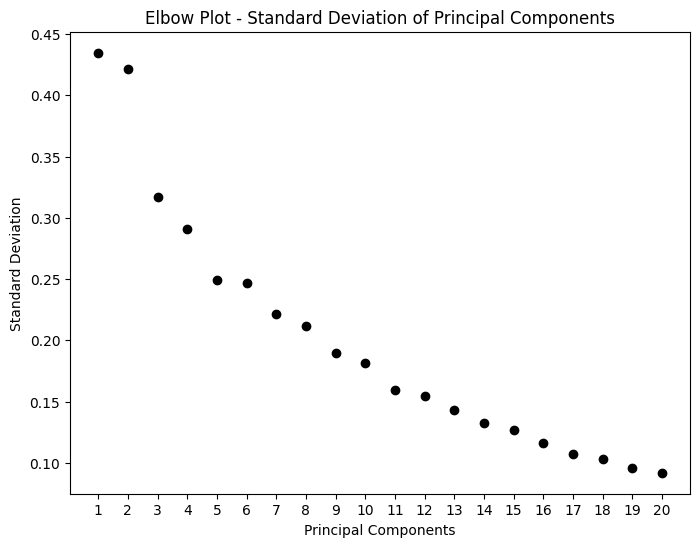

Principal Component 1 Standard Deviation: 0.4347135513110023
Principal Component 2 Standard Deviation: 0.4211088157619806
Principal Component 3 Standard Deviation: 0.3168190381002258
Principal Component 4 Standard Deviation: 0.29104915125442943
Principal Component 5 Standard Deviation: 0.24945579219152894
Principal Component 6 Standard Deviation: 0.2470228533966871
Principal Component 7 Standard Deviation: 0.2216233735615969
Principal Component 8 Standard Deviation: 0.2117451458963916
Principal Component 9 Standard Deviation: 0.18987583449825188
Principal Component 10 Standard Deviation: 0.181193271657041
Principal Component 11 Standard Deviation: 0.15957444975049603
Principal Component 12 Standard Deviation: 0.15490416339990773
Principal Component 13 Standard Deviation: 0.1430020133007263
Principal Component 14 Standard Deviation: 0.13245613656502944
Principal Component 15 Standard Deviation: 0.1263998704191577
Principal Component 16 Standard Deviation: 0.11621603356976548
Principal C

In [14]:
num_components = 20
pca = PCA(n_components=num_components)
pca.fit(shap_values_test.values)
pca_components = pca.transform(shap_values_test.values)

std_deviation = np.std(pca_components, axis=0)
num_components = len(std_deviation)

plt.figure(figsize=(8, 6))
plt.scatter(range(1, num_components + 1), std_deviation, color='black', marker='o')
plt.title('Elbow Plot - Standard Deviation of Principal Components')
plt.xlabel('Principal Components')
plt.ylabel('Standard Deviation')
plt.xticks(np.arange(1, num_components + 1))
plt.show()
for i, std in enumerate(std_deviation):
    print(f"Principal Component {i+1} Standard Deviation: {std}")

In [15]:
similarity_matrix = SC_nSNN(pca_components[:, :8],15,1.5)
num_clusters =4
clusters = spectral_clustering(similarity_matrix, num_clusters)
clusters_test = spectral_clustering(similarity_matrix, num_clusters)
for i in range(len(clusters)):
    if clusters[i] == 1:
        clusters[i] = 2
    elif clusters[i] == 2:
        clusters[i] = 1
for i in range(len(clusters)):
    if clusters[i] == 0:
        clusters[i] = 2
    elif clusters[i] == 2:
        clusters[i] = 0
for i in range(len(clusters)):
    if clusters[i] == 1:
        clusters[i] = 2
    elif clusters[i] == 2:
        clusters[i] = 1
for i in range(len(clusters)):
    if clusters[i] == 3:
        clusters[i] = 2
    elif clusters[i] == 2:
        clusters[i] = 3
def map_cluster_to_color2(cluster):
    if cluster == 0:
        return "orange"
    elif cluster == 1:
        return "blue"
    elif cluster == 2:
        return "green"
    elif cluster == 3:
        return "red"
    else:
        return "purple"
    
clusters_nr2 = [map_cluster_to_color(cluster) for cluster in clusters]

In [18]:
train_df = pd.DataFrame({
    'Sample': X_train.index.tolist(),   
    'Dataset': ['train'] * len(X_train),  
    'Label': ['R' if label == 1 else 'NR' for label in y_train],  
    'Cluster': clusters_train 
})

test_df = pd.DataFrame({
    'Sample': X_test.index.tolist(),    
    'Dataset': ['test'] * len(X_test),   
    'Label': ['R' if label == 1 else 'NR' for label in y_test], 
    'Cluster': clusters_test  
})

combined_df = pd.concat([train_df, test_df], ignore_index=True)

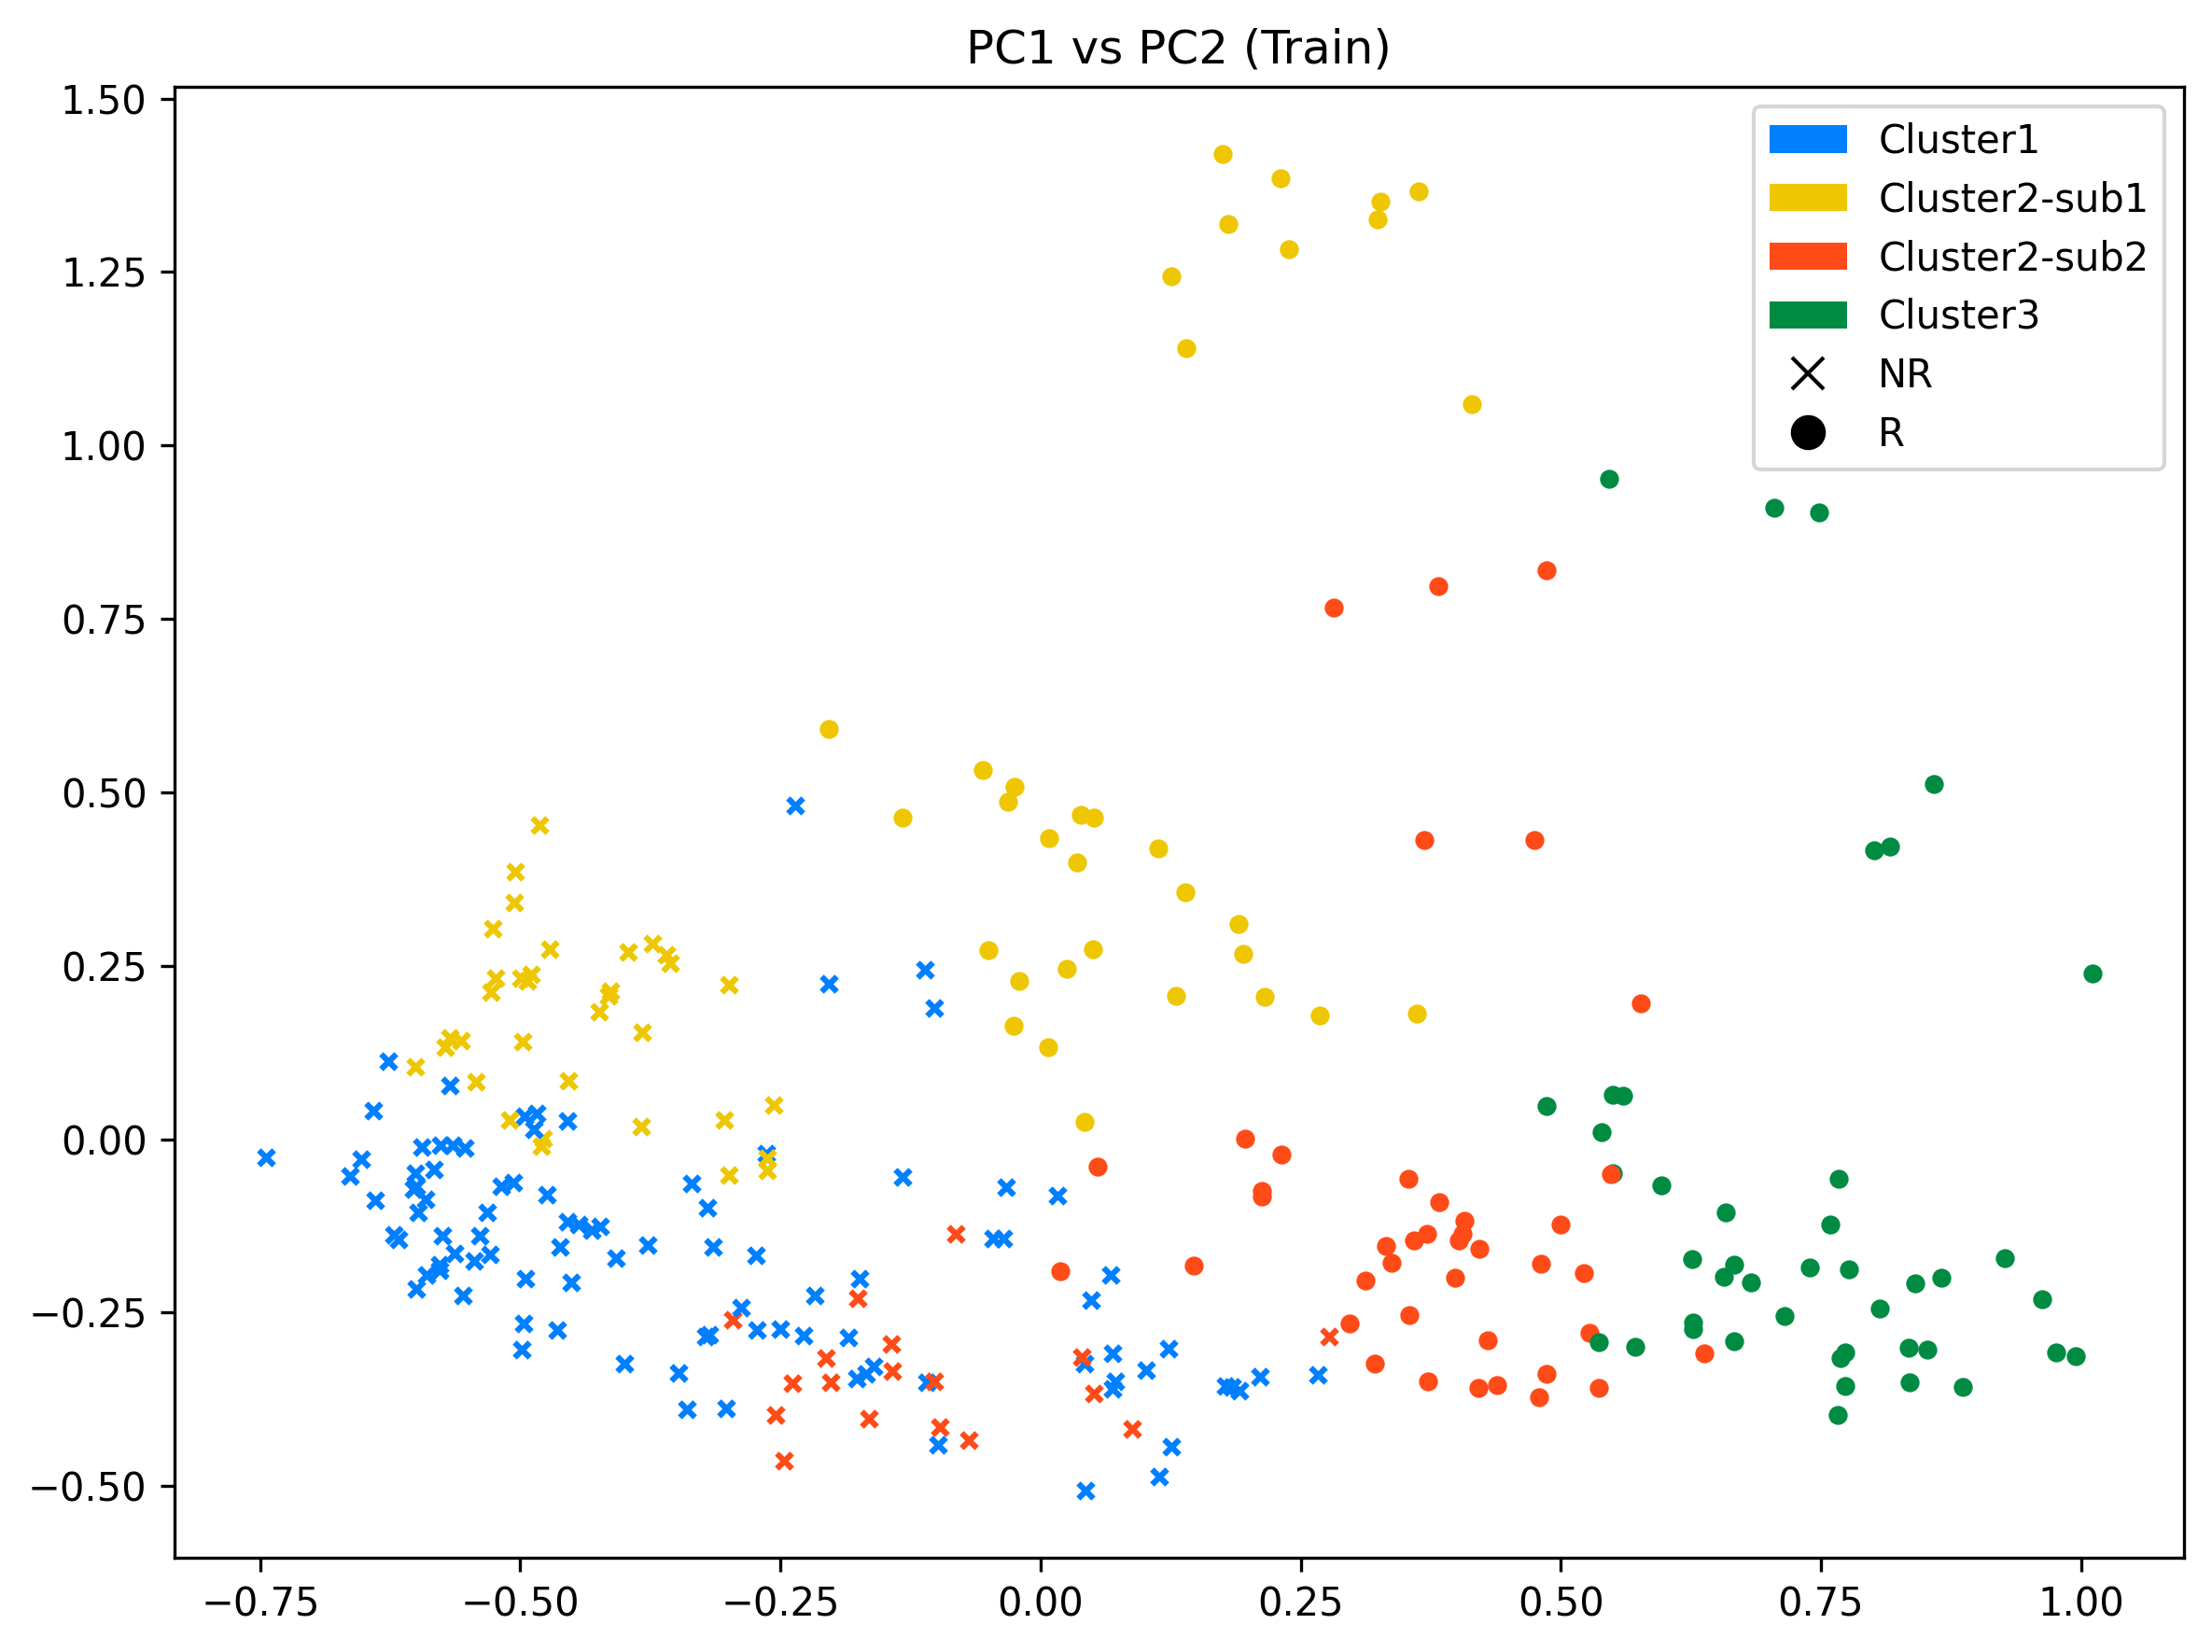

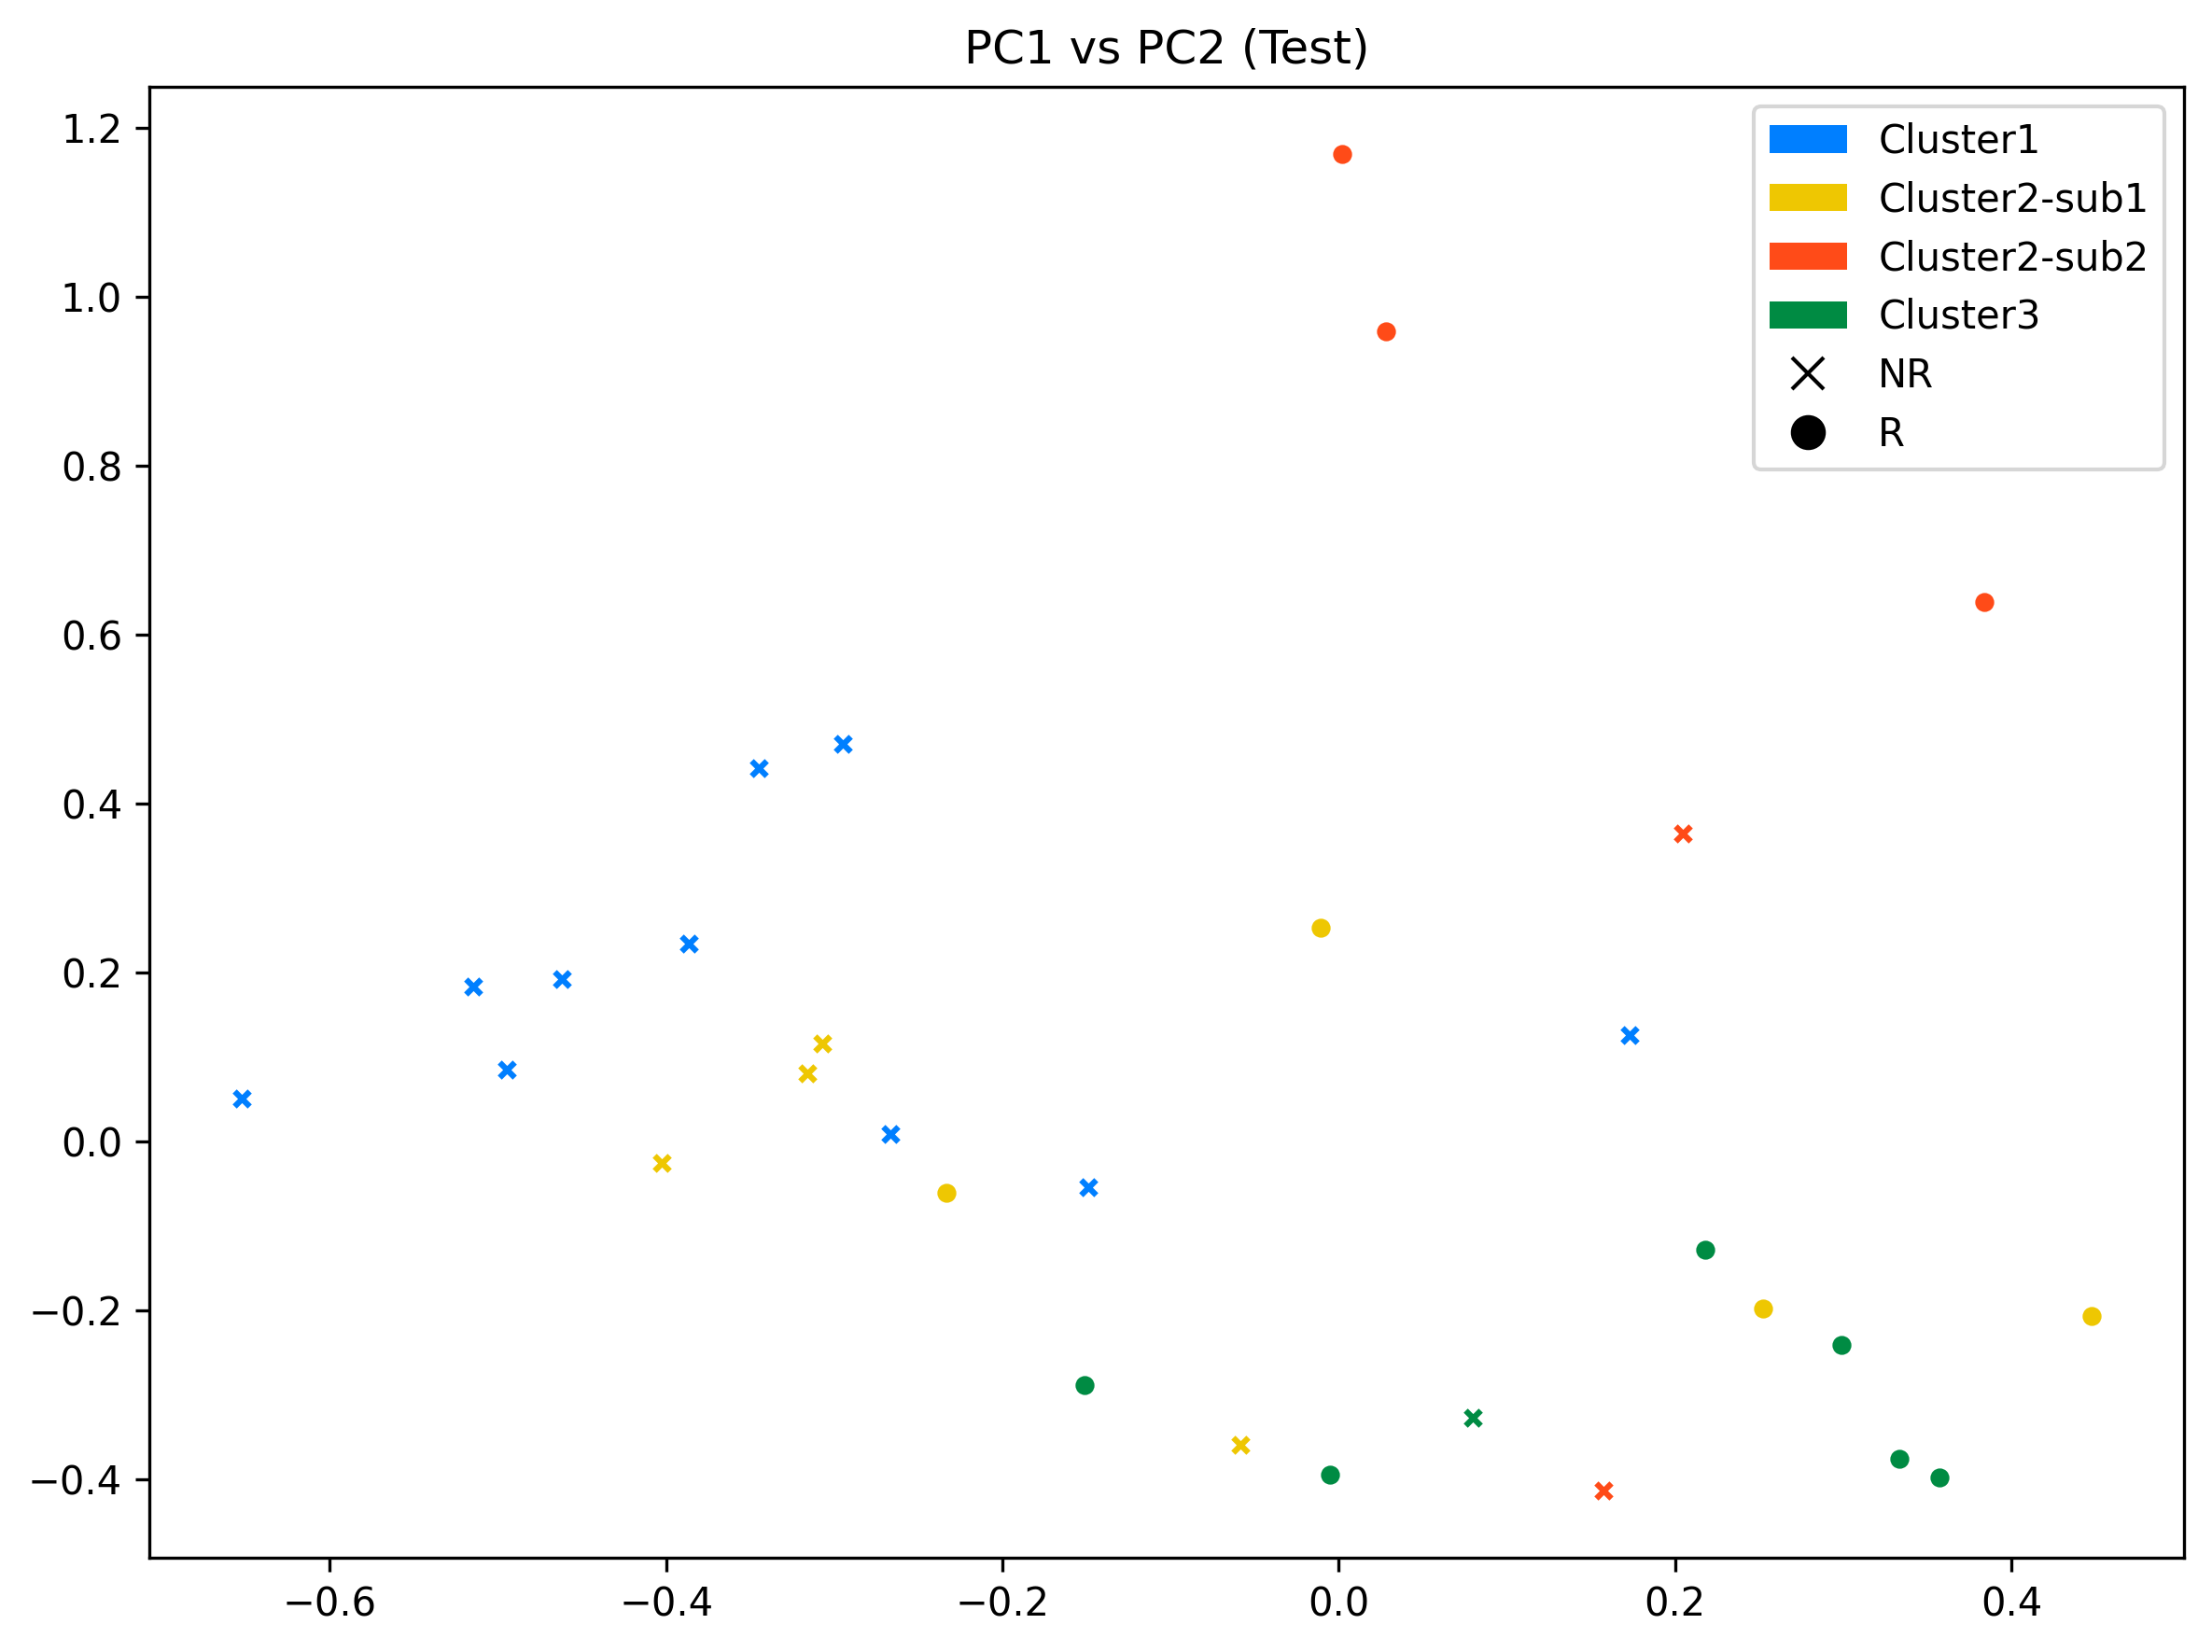

In [19]:
def get_marker(value):
    return 'x' if value == 0 else 'o'

color_all = clusters_nr+clusters_nr2

pca = PCA(n_components=2)
PCA_dat_all = pca.fit_transform(shap_values_values)  

PCA_train = PCA_dat_all[:len(y_train)]
PCA_test = PCA_dat_all[len(y_train):]

color_train = color_all[:len(y_train)]
color_test = color_all[len(y_train):]
txt_train = y_train
txt_test = y_test

plt.figure(figsize=(8, 6), dpi=300)
for i in range(len(PCA_train)):
    plt.scatter(PCA_train[i, 0], PCA_train[i, 1], color=color_train[i], marker=get_marker(txt_train[i]), s=15)
plt.title('PC1 vs PC2 (Train)')
plt.tight_layout()
legend_elements = [
    mpatches.Rectangle((0, 0), 1, 0.4, facecolor="#007FFF", label='Cluster1'),
    mpatches.Rectangle((0, 0), 1, 0.4, facecolor="#EEC702", label='Cluster2-sub1'),
    mpatches.Rectangle((0, 0), 1, 0.4, facecolor="#FF4B18", label='Cluster2-sub2'),
    mpatches.Rectangle((0, 0), 1, 0.4, facecolor="#008B43", label='Cluster3'),
    plt.Line2D([0], [0], marker='x', color='black', markersize=8, linestyle='None', label='NR'),
    plt.Line2D([0], [0], marker='o', color='black', markersize=8, linestyle='None', label='R')
]
plt.legend(handles=legend_elements, loc='upper right', fontsize=10)
plt.show()

plt.figure(figsize=(8, 6), dpi=300)
for i in range(len(PCA_test)):
    plt.scatter(PCA_test[i, 0], PCA_test[i, 1], color=color_test[i], marker=get_marker(txt_test[i]), s=15)
plt.title('PC1 vs PC2 (Test)')
legend_elements = [
    mpatches.Rectangle((0, 0), 1, 0.4, facecolor="#007FFF", label='Cluster1'),
    mpatches.Rectangle((0, 0), 1, 0.4, facecolor="#EEC702", label='Cluster2-sub1'),
    mpatches.Rectangle((0, 0), 1, 0.4, facecolor="#FF4B18", label='Cluster2-sub2'),
    mpatches.Rectangle((0, 0), 1, 0.4, facecolor="#008B43", label='Cluster3'),
    plt.Line2D([0], [0], marker='x', color='black', markersize=8, linestyle='None', label='NR'),
    plt.Line2D([0], [0], marker='o', color='black', markersize=8, linestyle='None', label='R')
]
plt.legend(handles=legend_elements, loc='upper right', fontsize=10)
plt.tight_layout()
plt.show()
